# Sum-of-Squares (SOS) optimization
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).


## Background
Sum-of-Squares (SOS) optimization is a special type of convex optimization. This type of optimization is formulated as a Semidefinite Programming (SDP) problem, which can be solved through several solvers supported by Drake's MathematicalProgram.

A polynomial $p(x)$ is sum-of-squares if

$\begin{aligned}
p(x) = \sum_i q_i(x)^2
\end{aligned}$

where each $q_i(x)$ is also a polynomial of the indeterminates $x$. $p(x)$ being sum-of-squares is a *sufficient* condition for $p(x)$ being non-negative for all $x$. In some cases it is also a necessary and sufficient condition. For more details on the relationship between sum-of-squares and non-negativity of a polynomial, you could refer to Chapter 3 of [Semidefinite Optimization and Convex Algebraic Geometry](http://www.mit.edu/~parrilo/sdocag/).

A polynomial $p(x)$ being sum-of-squares is equivalent to the existence of a positive semidefinite (psd) matrix $Q$, such that

$\begin{aligned}
p(x) = z(x)^T Q z(x), Q\succeq 0
\end{aligned}$

where $z(x)$ contains all the monomials of $x$ up to a certain degree. If $x\in\mathbb{R}^n$ and $p(x)$ has degree $2d$, then $z(x)$ contains all the monomials of $x$ up to degree $d$, namely the $z(x)$ has size ${{n+d}\choose{d}}$. So searching for a sum-of-squares polynomial $p(x)$ is equivalent to searching for a positive semidefinite matrix $Q$, with the additional constraint that the polynomials $z(x)^TQz(x)$ and $p(x)$ are the same (they have the same coefficients).

For example, for the polynomial

$\begin{aligned}
p(x) = 2x_1^4 + 5x_2^4 - 2x_1^2x_2^2 + 2x_1^3x_2 + 2x_1 + 2,
\end{aligned}$

we have

$\begin{aligned}
p(x) = \underbrace{\begin{bmatrix} 1 \\x_1 \\x_2 \\ x_1^2 \\ x_1x_2 \\ x_2^2\end{bmatrix}^T}_{z(x)^T} \underbrace{\frac{1}{3}\begin{bmatrix} 6 & 3 & 0 & -2 & 0 & -2\\ 3 & 4 & 0 & 0 & 0 & 0\\0 & 0 & 4 & 0 & 0 & 0\\-2 & 0 & 0 & 6 & 3 & -4\\ 0 & 0 & 0 & 3 & 5 & 0\\ -2 & 0 & 0 & -4 & 0 & 15\end{bmatrix}}_{Q} \underbrace{\begin{bmatrix} 1 \\ x_1 \\x_2 \\x_1^2 \\x_1x_2\\ x_2^2\end{bmatrix}}_{z(x)}
\end{aligned}$

where this $Q$ matrix is positive semidefinite, hence $p(x)$ is a sum-of-squares polynomial.
In fact, $p(x)$ can be decomposed as sum-of-squares 

$\begin{aligned}
p(x) = \frac{4}{3}x_2^2 + \frac{1349}{705}x_2^4 + \frac{1}{12}(4x_1+3)^2+\frac{1}{15}(3x_1^2+5x_1x_2)^2+\frac{1}{315}(-21x_1^2+20x_2^2+10)^2+\frac{1}{59220}(328x_2^2-235)^2
\end{aligned}$

## Solving sum-of-squares problem
In sum-of-squares problem, often we want to find a sum-of-squares polynomial that satisfies certain additional properties. Note that there are two different types of variables in sum-of-squares problems, the *indeterminates* and *decision variables*.
* Decision variables: the coefficients of the polynomial are affine functions of our decision variables. We are optimizing over the decision variables.
* Indeterminates: variables that can take any value. In the example above $x$ is an indeterminate -- the constraints that we write must hold $\forall x$, we are *not* optimizing over these indeterminates.

There are some functions commonly used in sum-of-squares optimization within Drake's MathematicalProgram. We list some of them here
* `MathematicalProgram.NewIndeterminates` Declares and returns new indeterminates.
* `MathematicalProgram.AddSosConstraint` Imposes sum-of-squares (SOS) constraint on a polynomial.
* `MathematicalProgram.NewSosPolynomial` Creates and returns a new polynomial, and constrain this polynomial to be sum-of-squares (SOS).
* `MathematicalProgram.NewFreePolynomial` Creates and returns a new polynomial. No constraint has been imposed on this polynomial yet.
* `MathematicalProgram.AddEqualityConstraintBetweenPolynomials` imposes the linear constraint that two polynomials are equal (they have the same coefficients for matching monomials).

We will describe the details of each function later. First let's look at some examples

### Imports

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt

from pydrake.solvers import MathematicalProgram, Solve
import pydrake.symbolic as sym

### Example 1
For example, if we want to solve the following optimization problem (Example 3.50 of [Semidefinite Optimization and Convex Algebraic Geometry](http://www.mit.edu/~parrilo/sdocag/))

$\begin{aligned}
\min_{a}& -a_0 - a_1\\
\text{s.t }& x^4 + a_0 x + 2 + a_1 \text{ is SOS}\\
&(a_0 - a_1 + 1)x^2 + a_1x + 1\text{ is SOS}
\end{aligned}$

in this case, $x$ is the indeterminate, and $a$ is the decision variables.

The code below shows how to model and solve this SOS problem in drake's MathematicalProgram.

In [ ]:
"""
Code for example 1.
"""

# Initialize an empty optimization program.
prog = MathematicalProgram()
# Declare "a" as decision variables.
a = prog.NewContinuousVariables(2)
# Declare "x" as indeterminates
x = prog.NewIndeterminates(1)

# Declare p1(x) = pow(x, 4) + a0 * x + 2 + a1. The second argument
# [x] indicates that the indeterminates in the polynomial is x.
p1 = sym.Polynomial(x[0]**4 + a[0] * x[0] + 2 + a[1], [x])
# Declare p2(x) = (a0 - a1 + 1) * pow(x, 2) + a1 * x + 1. The second argument
# [x] indicates that the indeterminates in the polynomial is x.
p2 = sym.Polynomial((a[0] - a[1] + 1) * x[0] * x[0] + a[1] * x[0] + 1, [x])
# Add the constraint that p1(x) and p2(x) are SOS
prog.AddSosConstraint(p1)
prog.AddSosConstraint(p2)

# Add the cost -a0 - a1
prog.AddCost(-a[0] - a[1])

# Solve the problem.
result = Solve(prog)

# Retrieve the solution.
print(result.get_solution_result())
print("a =", result.GetSolution(a))

SolutionResult.kSolutionFound
a = [6.6189036  3.87159385]


### Example 2

$\begin{aligned}
\min_{a, b, c}&\; a + b + c\\
\text{s.t }& x^4 + ax^3 + bx^2 + cx + 1 \ge 0 \quad\forall x\in[0, 1]
\end{aligned}$

To solve this problem, we use a special case of Theorem 3.72 from
[Semidefinite Optimization and Convex Algebraic Geometry](http://www.mit.edu/~parrilo/sdocag/):
An even degree univariate polynomial $p(x)$ is nonnegative on interval $[0, 1]$ if and only if it can be written as

$\begin{aligned}
p(x) = s(x) + x(1-x)t(x)
\end{aligned}$

where $s(x), t(x)$ are both sum-of-squares.

Hence we can reformulate the problem as

$\begin{aligned}
\min_{a, b, c, t}&\; a+b+c\\
\text{s.t }& x^4 + ax^3 + bx^2 + cx + 1 - x(1-x)t(x) \text{ is SOS}\\
& t(x) \text{ is SOS}
\end{aligned}$

here $x$ is the indeterminate, $a, b, c$ and the coefficients of polynomial $t(x)$ are the decision variables. The code below shows how to model and solve this problem in drake's MathematicalProgram

Is success?  True
SolutionResult.kSolutionFound


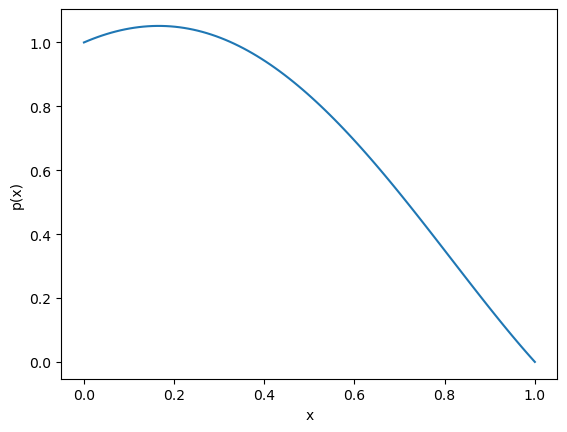

In [ ]:
"""
Code for example 2.
"""

# Initialize an empty optimization program.
prog = MathematicalProgram()
# Declares indeterminates
x = prog.NewIndeterminates(1)

# Declares decision variable a, b, and c
a = prog.NewContinuousVariables(1)[0]
b = prog.NewContinuousVariables(1)[0]
c = prog.NewContinuousVariables(1)[0]

# Declare p(x), the second argument indicates this polynomial p(x) has x as the
# indeterminates.
poly_p = sym.Polynomial(x[0]**4 + a * x[0]**3 + b * x[0]** 2 + c * x[0] + 1, [x])
# Declares SOS polynomial t(x), such that s(x) = p(x) - x(1-x) * t(x) is SOS.
# The second return argument of NewSosPolynomial is the positive-semidefinite
# Gramian matrix of poly_s. We ignore this matrix here.
# t(x) should be a quadratic polynomial of x, hence the second input argument is
# 2, indicating the degree of the returned polynomial.
poly_t, _ = prog.NewSosPolynomial(sym.Variables(x), 2)
# Compute s(x) = p(x) - x(1-x)t(x) as a polynomial of indeterminate x.
poly_s = poly_p - sym.Polynomial(x[0] * (1 - x[0]), sym.Variables(x)) * poly_t
prog.AddSosConstraint(poly_s)

# Add the cost a + b + c
prog.AddCost(a + b + c)

result = Solve(prog)
print("Is success? ", result.is_success())
print(result.get_solution_result())
a_val = result.GetSolution(a)
b_val = result.GetSolution(b)
c_val = result.GetSolution(c)

# Now plot the polynomial p(x), that is always non-negative in the range [0, 1]
x_val = np.linspace(0, 1, 100)
y_val = np.power(x_val, 4) + a_val * np.power(x_val, 3) + b_val * np.power(x_val, 2) + c_val * x_val + 1
plt.xlabel("x")
plt.ylabel("p(x)")
plt.plot(x_val, y_val)

## Further readings

Sum-of-squares optimization has been widely used in numerous fields, including control theory, robotics, quantum information theory, etc. Here are some references

#### Sum-of-squares theory
* [Semidefinite Optimization and Convex Algebraic Geometry](http://www.mit.edu/~parrilo/sdocag/) by G Blekherman, P Parrilo and R Thomas
* [Sum of squares techniques and polynomial optimization](http://www.princeton.edu/~amirali/Public/Presentations/CDC_2016_Parrilo_1) Presentation slides by Pablo Parrilo

#### System control theory
* [Structured Semidefinite Programs and Semialgebraic Geometry Methods in Robustness and Optimization](http://www.mit.edu/~parrilo/pubs/files/thesis.pdf) Pablo Parrilo's PhD thesis
* [Robust Region-of-Attraction Estimation](https://ieeexplore.ieee.org/abstract/document/5337881) Ufuk Topcu, Andrew Packard, Peter Seiler, Gary Balas, IEEE Transactions on Automatic Control, 2009

#### Robotics
* [LQR-trees: Feedback motion planning via sums-of-squares verification](http://groups.csail.mit.edu/robotics-center/public_papers/Tedrake10.pdf) Russ Tedrake, Ian Manchester, Mark Tobenkin, John Roberts, International Journal of Robotics Research, 2010
* [Funnel libraries for real-time robust feedback motion planning](http://groups.csail.mit.edu/robotics-center/public_papers/Majumdar16.pdf) Anirudha Majumdar and Russ Tedrake, International Journal of Robotics Research, 2017

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=daec9c67-c271-4556-b3d6-020f0178ac09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>